In [2]:
import os
import numpy as np
from PIL import Image
import glob
import os.path as osp
import matplotlib.pyplot as plt

In [2]:
# 디렉토리 경로 설정
input_image_dir = "./JPEGImages"
input_mask_dir = "./SegmentationClassNpy"
output_dir = "./MaskedImages"

# 출력 디렉토리가 없으면 생성
if not osp.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
# 마스킹할 클래스 ID 정의
# 예: "Ribs Lt"=1, "Ribs Rt"=2
allowed_classes = [5, 6]

In [4]:
# 모든 JPEG 이미지 파일 목록 가져오기
image_files = sorted(glob.glob(osp.join(input_image_dir, "*.jpg")))

# 매칭되는 마스크 파일 존재 여부 확인
matched_files = []
for img_path in image_files:
    base = osp.splitext(osp.basename(img_path))[0]
    mask_path = osp.join(input_mask_dir, base + ".npy")
    if osp.exists(mask_path):
        matched_files.append((img_path, mask_path))
    else:
        print(f"마스크 파일을 찾을 수 없습니다: {mask_path}")

In [6]:
for img_path, mask_path in matched_files:
    base = osp.splitext(osp.basename(img_path))[0]

    # 원본 이미지 로드
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # 마스크 로드
    mask = np.load(mask_path)

    # allowed_classes에 해당하는 부분만 유지하고 나머지는 0으로 설정
    binary_mask = np.isin(mask, allowed_classes).astype(
        np.uint8
    )  # 1과 0으로 구성된 이진 마스크

    # 이진 마스크를 3채널로 확장
    binary_mask_3ch = np.stack([binary_mask] * 3, axis=-1)

    # 마스크 적용: 마스크가 1인 부분은 원본 이미지, 0인 부분은 검은색
    masked_img_np = img_np * binary_mask_3ch

    # NumPy 배열을 PIL 이미지로 변환
    masked_img = Image.fromarray(masked_img_np)

    # 저장 경로 설정
    out_path = osp.join(output_dir, base + "_masked.jpg")
    masked_img.save(out_path)

    print(f"저장된 마스크 이미지: {out_path}")

저장된 마스크 이미지: ./MaskedImages\processed_0000403_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0000437_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0004169_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0004330_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0005418_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0006161_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0019225_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0033327_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0033979_masked.jpg
저장된 마스크 이미지: ./MaskedImages\processed_0034546_masked.jpg


c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canv

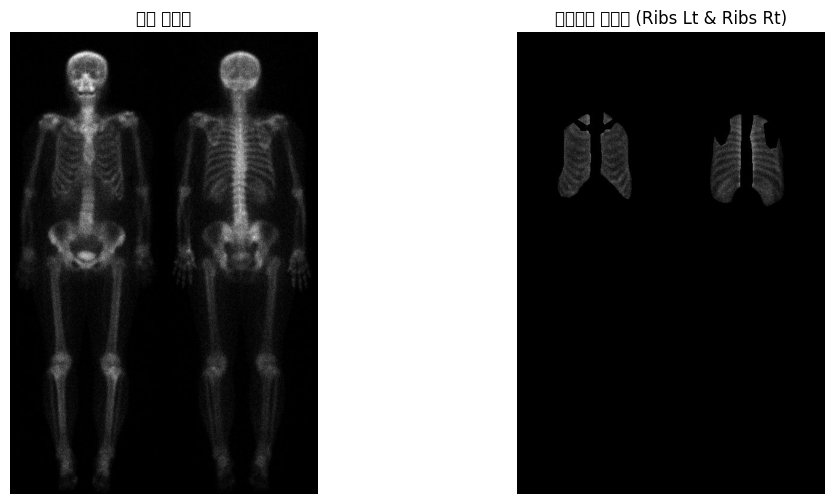

In [ ]:
# 예시: 첫 번째 마스킹된 이미지 표시
if matched_files:
    sample_img_path, sample_mask_path = matched_files[0]
    base = osp.splitext(osp.basename(sample_img_path))[0]
    masked_img_path = osp.join(output_dir, base + "_masked.jpg")

    # 원본 이미지
    original_img = Image.open(sample_img_path).convert("RGB")

    # 마스킹된 이미지
    masked_img = Image.open(masked_img_path).convert("RGB")

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_img)
    axes[0].set_title("원본 이미지")
    axes[0].axis("off")

    axes[1].imshow(masked_img)
    axes[1].set_title("마스킹된 이미지 (Ribs Lt & Ribs Rt)")
    axes[1].axis("off")

    plt.show()

In [5]:
import os
import numpy as np
from PIL import Image
import glob
import os.path as osp
import matplotlib.pyplot as plt
from tqdm import tqdm  # 진행 상황 표시

In [4]:
# 디렉토리 경로 설정
input_dir = "./MaskedImages"
output_dir = "./TrimmedImages"

# 출력 디렉토리가 없으면 생성
if not osp.exists(output_dir):
    os.makedirs(output_dir)

In [6]:
# 모든 마스킹된 이미지 파일 목록 가져오기
masked_image_files = sorted(glob.glob(osp.join(input_dir, "*_masked.jpg")))

for img_path in tqdm(masked_image_files, desc="트리밍 진행 중"):
    try:
        base = osp.splitext(osp.basename(img_path))[0]

        # 마스킹된 이미지 로드 (그레이스케일로 변환)
        img = Image.open(img_path).convert(
            "L"
        )  # 'L' 모드로 변환하여 그레이스케일 이미지 생성
        img_np = np.array(img)

        # Otsu의 이진화 적용
        # Pillow에서는 직접적으로 Otsu를 지원하지 않으므로, numpy를 이용하여 구현
        # 히스토그램 계산
        hist, bin_edges = np.histogram(img_np, bins=256, range=(0, 255))

        total = img_np.size
        current_max, threshold = 0, 0
        sum_total, sum_foreground = 0, 0
        weight_background, weight_foreground = 0, 0

        for i in range(256):
            sum_total += i * hist[i]

        for i in range(256):
            weight_background += hist[i]
            if weight_background == 0:
                continue
            weight_foreground = total - weight_background
            if weight_foreground == 0:
                break
            sum_foreground += i * hist[i]

            mean_background = sum_foreground / weight_background
            mean_foreground = (sum_total - sum_foreground) / weight_foreground

            # Between Class Variance
            variance_between = (
                weight_background
                * weight_foreground
                * (mean_background - mean_foreground) ** 2
            )

            if variance_between > current_max:
                current_max = variance_between
                threshold = i

        # 임계값 적용하여 이진화
        threshold = 20
        binary_mask = (img_np > threshold).astype(
            np.uint8
        ) * 255  # 0과 255로 구성된 이진 마스크

        # 이진 마스크를 3채널로 확장하여 원본 이미지와 동일한 형태로 만듦
        binary_mask_3ch = np.stack([binary_mask] * 3, axis=-1)

        # 원본 마스킹된 이미지 로드 (RGB)
        img_rgb = Image.open(img_path).convert("RGB")
        img_rgb_np = np.array(img_rgb)

        # 트리밍: 마스크가 255인 부분만 원본 이미지 유지, 나머지는 검은색으로 설정
        trimmed_img_np = img_rgb_np * (binary_mask_3ch // 255)

        # NumPy 배열을 PIL 이미지로 변환
        trimmed_img = Image.fromarray(trimmed_img_np)

        # 저장 경로 설정
        out_path = osp.join(output_dir, base + "_trimmed.jpg")
        trimmed_img.save(out_path)

    except Exception as e:
        print(f"이미지 처리 중 에러 발생 ({base}): {e}")
        continue

트리밍 진행 중: 100%|██████████| 10/10 [00:00<00:00, 44.56it/s]


c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\chona\Manual_Labeling\nhenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53433 (\N{HANGUL SYLLABLE KING}) missing from current font.
  fig.

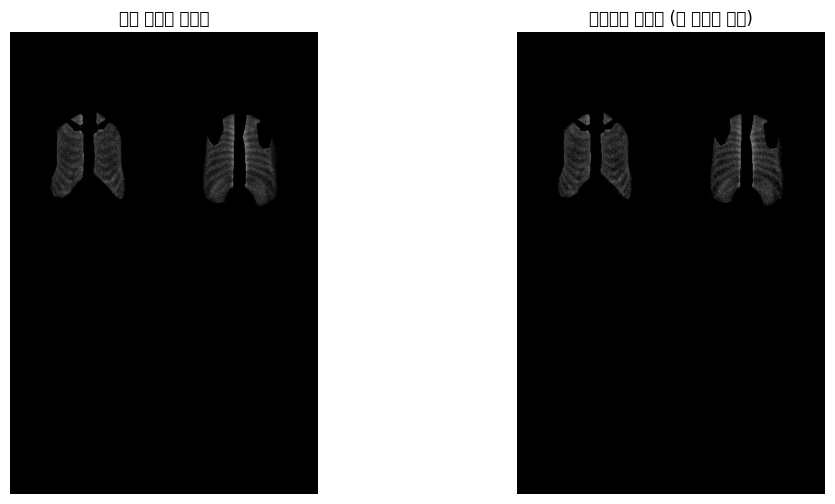

In [7]:
# 트리밍된 이미지 파일 목록 가져오기
trimmed_image_files = sorted(glob.glob(osp.join(output_dir, "*_trimmed.jpg")))

# 트리밍된 첫 번째 이미지 시각화
if trimmed_image_files:
    sample_trimmed_img_path = trimmed_image_files[0]
    sample_trimmed_img = Image.open(sample_trimmed_img_path).convert("RGB")

    # 원본 마스킹된 이미지
    original_masked_img_path = osp.join(
        input_dir, osp.basename(sample_trimmed_img_path).replace("_trimmed.jpg", ".jpg")
    )
    original_masked_img = Image.open(original_masked_img_path).convert("RGB")

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(original_masked_img)
    axes[0].set_title("원본 마스킹 이미지")
    axes[0].axis("off")

    axes[1].imshow(sample_trimmed_img)
    axes[1].set_title("트리밍된 이미지 (뼈 부분만 남음)")
    axes[1].axis("off")

    plt.show()

In [ ]:
manual_threshold = 150  # 원하는 임계값으로 설정

# 이진 마스크 생성
binary_mask = (img_np > manual_threshold).astype(np.uint8) * 255

In [ ]:
import cv2

# 마스크 로드 후, Otsu의 이진화 적용 대신 OpenCV 사용
# 이미지 로드
img = Image.open(img_path).convert("L")
img_np = np.array(img)

# Otsu의 이진화 적용
ret, binary_mask = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 모폴로지 연산: 침식 후 팽창 (열림, Opening)
kernel = np.ones((3, 3), np.uint8)
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=2)

# 이후 트리밍 적용
# ...

In [ ]:
# 트리밍된 이미지 저장 (PNG 형식, 투명 배경)
alpha_channel = binary_mask  # 이진 마스크를 알파 채널로 사용
img_rgba = Image.fromarray(trimmed_img_np).convert("RGBA")
img_rgba.putalpha(Image.fromarray(alpha_channel))
out_path = osp.join(output_dir, base + "_trimmed.png")
img_rgba.save(out_path)

In [ ]:
# 다양한 임계값 시도 및 시각화
threshold_values = [100, 150, 200]

for thresh in threshold_values:
    binary_mask = (img_np > thresh).astype(np.uint8) * 255
    binary_mask_3ch = np.stack([binary_mask] * 3, axis=-1)
    trimmed_img_np = img_rgb_np * (binary_mask_3ch // 255)
    trimmed_img = Image.fromarray(trimmed_img_np)

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_rgb)
    axes[0].set_title("원본 마스킹 이미지")
    axes[0].axis("off")

    axes[1].imshow(trimmed_img)
    axes[1].set_title(f"트리밍된 이미지 (Threshold={thresh})")
    axes[1].axis("off")

    plt.show()

In [ ]:
# 임계값 시각화 예제 (첫 번째 이미지)
if masked_image_files:
    sample_img_path = masked_image_files[0]
    base = osp.splitext(osp.basename(sample_img_path))[0]

    # 마스킹된 이미지 로드 (그레이스케일)
    img = Image.open(sample_img_path).convert("L")
    img_np = np.array(img)

    # Otsu의 이진화 적용
    ret, binary_mask = cv2.threshold(
        img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 원본 그레이스케일 이미지와 이진 마스크 시각화
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(img_np, cmap="gray")
    axes[0].set_title("원본 그레이스케일 이미지")
    axes[0].axis("off")

    axes[1].imshow(binary_mask, cmap="gray")
    axes[1].set_title(f"Otsu 이진화 (Threshold={ret})")
    axes[1].axis("off")

    plt.show()